In [ ]:
import torch
import torch.optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

# -------------- Gain dataset From pickle file -------------- #
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def get_data(path, leng_data):
    dataset = unpickle(path)
    data_x = [data for index, data in enumerate(dataset[b'data'])]#Unpackage the file and gain all dataset with label of data
    data_x = np.array(data_x)
    data_y = [data for index, data in enumerate(dataset[b'labels'])]#Unpackage the file and gain all dataset with label of labels
    data_y = np.array(data_y)
   
    data_x_red   = data_x[:leng_data, :1024]#red color saved is first 1024 elements
    data_x_green = data_x[:leng_data, 1024:2048]#green color saved is first 1024 elements
    data_x_blue  = data_x[:leng_data, 2048:]#blue color saved is first 1024 elements
    red   = data_x_red.reshape(len(data_x_red), 32, 32) # original elements in shape of (1,1024), reshape them into 32 * 32 matrix
    green = data_x_green.reshape(len(data_x_green), 32, 32)
    blue  = data_x_blue.reshape(len(data_x_blue), 32, 32)


    sample = np.stack([red, green, blue], axis=1).astype(np.float32) / 255.0 #Convert the elements into 32 bits float and normalize the data
    label  = data_y[:leng_data] #Gain all y label dataset
    return sample, label

In [ ]:
# -------------- Attention -------------- #
class SEBlock(torch.nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.squeeze = torch.nn.AdaptiveAvgPool2d(1)  # adaptive average pool layer
        self.excitation = torch.nn.Sequential(
            torch.nn.Linear(channels, channels // reduction, bias=False),  # decrease the channel dimension
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(channels // reduction, channels, bias=False),  # increase the channel dimension
            torch.nn.Sigmoid()  # scale the weight in [0,1]
        )

    def forward(self, x):
        b, c, _, _ = x.shape
        y = self.squeeze(x).view(b, c)  # Decrease the dimension
        y = self.excitation(y).view(b, c, 1, 1)  # Compute channel-wise attention weights
        return x * y  #Apply channel-wise reweighting

# ----------------- ResNet model definition ----------------- #
class block(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride, signal):
        super(block, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False) #Define the frist convolution layer
        self.bn1   = torch.nn.BatchNorm2d(out_channels) # batch normalize
        self.relu  = torch.nn.ReLU(inplace=True)# activation
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)#Second convolution layer
        self.bn2   = torch.nn.BatchNorm2d(out_channels)#second normalized
        self.se    = SEBlock(out_channels) if signal else torch.nn.Identity()  #add SE Block
        if in_channels != out_channels or stride != 1: #If we switch the size of features, we need to reshape the input identity size
            self.connection = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                torch.nn.BatchNorm2d(out_channels)
            )
        else:
            self.connection = torch.nn.Identity()

    def forward(self, x):
        identity = self.connection(x)#Apply all the layer
        out = self.conv1(x)#One resnet box need 2 conv, 2 batch normalized, 2 activation(Relu) and 1 se
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)  
        out += identity
        out = self.relu(out)
        return out

class layers(torch.nn.Module):
    def __init__(self, layer_num, in_channels, out_channels, stride, signal):
        super(layers, self).__init__()
        block_list = []
        for i in range(layer_num):
            if i == 0:#only the first laye need to dealing with switch channel sizes
                block_list.append(block(in_channels, out_channels, stride, signal))
            else:
                block_list.append(block(out_channels, out_channels, 1, signal))
        self.layer = torch.nn.Sequential(*block_list)#make all block in one sequential as one layer


    def forward(self, x):
        return self.layer(x)#return the layer box

class Resnet(torch.nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.Ci = [32, 64, 128, 256]#saving the numbers of channels
        self.conv1 = torch.nn.Conv2d(3, self.Ci[0], 3, 1, 1, bias=True)#The input first get 1 convolution layer with batch normalize and Relue
        self.bn1 = torch.nn.BatchNorm2d(self.Ci[0])
        self.relu = torch.nn.ReLU(inplace=True)
        self.layer1 = layers(2, self.Ci[0], self.Ci[0], 1, False)# second layer 2 is the number of layer, Ci shows the in_channle and out_chanle
        self.layer2 = layers(2, self.Ci[0], self.Ci[1], 2, False)# 1 or 2 decide the stride which define the scan speed of kernel
        self.layer3 = layers(2, self.Ci[1], self.Ci[2], 2, True)# Single determine weather we want to add se
        self.layer4 = layers(2, self.Ci[2], self.Ci[3], 2, True)
        self.avgpool= torch.nn.AdaptiveAvgPool2d((1, 1))#last adaptive pool
        self.dropout = torch.nn.Dropout(0.2) #Solve the problem of overfitting
        self.fc = torch.nn.Linear(self.Ci[3], 10)

    def forward(self, x):
        x = self.conv1(x)#apply all the convolution, batch normalize , and relu with layers
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)# resize x
        x = self.dropout(x)
        x = self.fc(x)#final output size linear fc function
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)#print the number of parameters

In [ ]:
# -----------------Cutout ----------------- #
class Cutout(object):
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes # Number of cutout holes
        self.length = length # Side length of each cutout hole

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        for _ in range(self.n_holes):
            #random select the point for cut off
            y = np.random.randint(h)
            x = np.random.randint(w)
           
            y1 = int(np.clip(y - self.length // 2, 0, h))
            y2 = int(np.clip(y + self.length // 2, 0, h))
            x1 = int(np.clip(x - self.length // 2, 0, w))
            x2 = int(np.clip(x + self.length // 2, 0, w))
            img[:, y1:y2, x1:x2] = 0
        return img

# -------------- Mixup  -------------- #
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    #make two images mixed together
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]#mixed to generate mixed dataset
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ---------------- Normalized Dataset ---------------- #
class transform_dataset(Dataset):
    def __init__(self, x_tensor, y_tensor, transform=None):
        super().__init__()
        self.x_tensor = x_tensor
        self.y_tensor = y_tensor
        self.transform = transform

    def __len__(self):
        return len(self.x_tensor)#length of tensor for data input

    def __getitem__(self, index):
        x = self.x_tensor[index]
        y = self.y_tensor[index]
        if self.transform:
            x = self.transform(x)#apply the transformer
        return x, y

# -------------- Read data & Make dataLoader -------------- #
cifar_mean = (0.4914, 0.4822, 0.4465)#the mean setting
cifar_std  = (0.35, 0.35, 0.35)#the stand deviation setting

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),#enhance the color of image
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),#Make it in tensor
    transforms.Normalize(cifar_mean, cifar_std),#normalize the image
    Cutout(n_holes=1, length=16)#image cutoff image enhancement
])
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])

path_list = ["./data_batch_1", "./data_batch_2", "./data_batch_3", "./data_batch_4", "./data_batch_5"]#read the dataset from the current folder
x_list, y_list = [], []
for p in path_list:
    sample, label = get_data(p, 10000)  # read all 10000 dataset and labels
    x_list.append(torch.tensor(sample))
    y_list.append(torch.tensor(label))

x_tensor = torch.cat(x_list, dim=0)
y_tensor = torch.cat(y_list, dim=0)
dataset_train = transform_dataset(x_tensor, y_tensor, transform=train_transforms)
data_loader_train = DataLoader(dataset_train, batch_size=128, shuffle=True)#make data loader for train

# test dataset
test_sample, test_label = get_data("./test_batch", 10000)#read all the testset data
x_tensor_test = torch.tensor(test_sample)
y_tensor_test = torch.tensor(test_label)
dataset_test = transform_dataset(x_tensor_test, y_tensor_test, transform=test_transform)
data_loader_test = DataLoader(dataset_test, batch_size=128, shuffle=False)#make the testset for test

Training parameters: 2818122
Epoch 1/250, LR=0.00667, Train loss: 2.0100,Test loss: 1.7121,accuracy: 0.4449
Epoch 2/250, LR=0.01333, Train loss: 1.8037,Test loss: 1.4952,accuracy: 0.5165
Epoch 3/250, LR=0.02000, Train loss: 1.6786,Test loss: 1.3317,accuracy: 0.6136
Epoch 4/250, LR=0.02667, Train loss: 1.6004,Test loss: 1.2313,accuracy: 0.6507
Epoch 5/250, LR=0.03333, Train loss: 1.5455,Test loss: 1.1571,accuracy: 0.6917
Epoch 6/250, LR=0.04000, Train loss: 1.5235,Test loss: 1.0330,accuracy: 0.7492
Epoch 7/250, LR=0.04667, Train loss: 1.4766,Test loss: 1.0265,accuracy: 0.7540
Epoch 8/250, LR=0.05333, Train loss: 1.4551,Test loss: 1.0736,accuracy: 0.7237
Epoch 9/250, LR=0.06000, Train loss: 1.4312,Test loss: 1.0680,accuracy: 0.7331
Epoch 10/250, LR=0.06667, Train loss: 1.4174,Test loss: 0.9683,accuracy: 0.7701
Epoch 11/250, LR=0.07333, Train loss: 1.3961,Test loss: 1.1254,accuracy: 0.7053
Epoch 12/250, LR=0.08000, Train loss: 1.3680,Test loss: 1.0825,accuracy: 0.7225
Epoch 13/250, LR=0.0

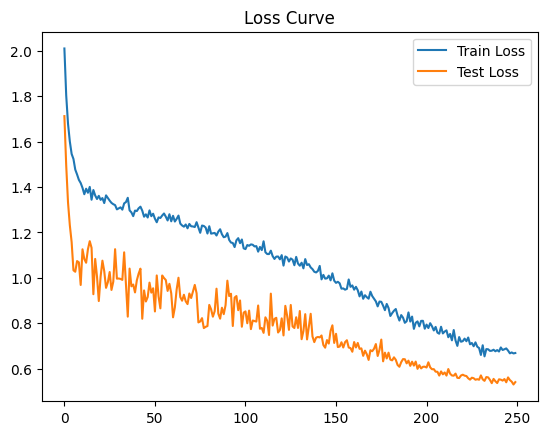

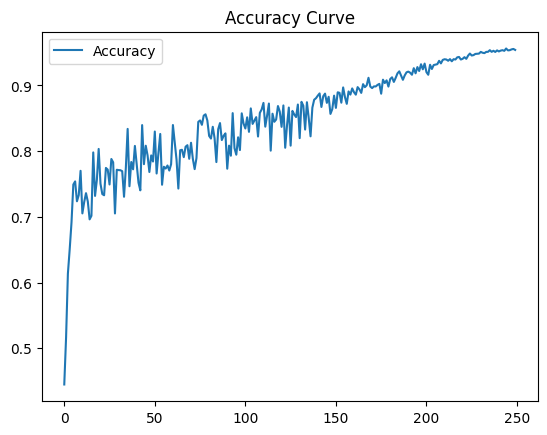

In [15]:
# ----------------- model training and optimizer ----------------- #
model = Resnet().cuda()#initialize the resnet model
print("Training parameters:", count_parameters(model))

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.08)#make loss function

initial_lr = 0.1  # initialize the learning rate
opt = torch.optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-4)#apply sdg optimizer method

epoch_len = 250
warmup_epochs = 15
# total epochs for scheduler
cosine_anneal_epochs = epoch_len - warmup_epochs

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    opt,
    T_max=cosine_anneal_epochs,
    eta_min=0.001  # set the minimize learning rate
)

# ----------------- training loop (with Warmup + Cosine + Mixup) ----------------- #
train_loss_hist = []
test_loss_hist  = []
accuracy_hist   = []

for epoch in range(epoch_len):
    # update the learning rate
    if epoch < warmup_epochs:#After the warm up stage, start the scheduler
        warmup_lr = initial_lr * float(epoch + 1) / float(warmup_epochs)
        for param_group in opt.param_groups:
            param_group['lr'] = warmup_lr
    else:
        scheduler.step(epoch - warmup_epochs)
       
    model.train()# train mode
    train_loss = 0.0
    for i, (images, labels) in enumerate(data_loader_train):
        images = images.cuda()#transfer image and labels to gpu
        labels = labels.long().cuda()

        alpha_mixup = max(0.1, 0.4 * (1 - epoch / epoch_len))#mixed up alpha calculated
        images, y_a, y_b, lam = mixup_data(images, labels, alpha=alpha_mixup)#apply dataset image with mixed up

        opt.zero_grad()#start the gradient descent
        outputs = model(images)#calculate the output of model
        loss = mixup_criterion(loss_fn, outputs, y_a, y_b, lam)#use loss function to find the loss for train
        loss.backward()
        opt.step()
        train_loss += loss.item()
       
    train_loss /= len(data_loader_train)#calculate the total loss for each train

    # test the accuracy stage
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader_test:
            images = images.cuda()
            labels = labels.long().cuda()
            outputs = model(images)
            loss_v  = loss_fn(outputs, labels)
            test_loss += loss_v.item()

            _, pred = torch.max(outputs, dim=1)
            correct += (pred == labels).sum().item()#compare the predict table with true labels
            total   += labels.size(0)
    test_loss /= len(data_loader_test)
    acc = correct / total#calculate the accuracy
   
    #add all the outcome to matrix
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    accuracy_hist.append(acc)


    #print the learning rate and accuracy and train loss and test loss and current epoch
    current_lr = opt.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{epoch_len}, LR={current_lr:.5f}, "
          f"Train loss: {train_loss:.4f},"
          f"Test loss: {test_loss:.4f},"
          f"accuracy: {acc:.4f}")

# ----------------- image and plot----------------- #
plt.figure()
plt.plot(train_loss_hist, label='Train Loss')#Apply the train loss plot
plt.plot(test_loss_hist, label='Test Loss')#Apply the test loss plot
plt.legend()
plt.title('Loss Curve')
plt.show()

plt.figure()
plt.plot(accuracy_hist, label='Accuracy')#Apply the accuracy
plt.legend()
plt.title('Accuracy Curve')
plt.show()

In [16]:
import csv

test_dict = unpickle("cifar_test_nolabel.pkl")#The kaggle required non labels packages  
test_x = test_dict[b'data'].astype(np.float32) / 255.0  # first normalize and convert to 32 bits float dataset
test_x = np.transpose(test_x, (0, 3, 1, 2))#transfer the dataset from (b,w,h,c) to (b,c,w,h) to satisfy the convolution 2d module
test_tensor = torch.tensor(test_x)#transfer to tensor
dummy_labels = torch.zeros(len(test_tensor))#gain the label
dataset_test_nolabel = transform_dataset(test_tensor, dummy_labels, transform=test_transform)#make dataset testloader
dataloader_test_nolabel = DataLoader(dataset_test_nolabel, batch_size=128, shuffle=False)

# evaluate the mode;
model.eval()
predictions = []
with torch.no_grad():
    for images, _ in dataloader_test_nolabel:
        images = images.cuda()
        outputs = model(images)
        predicted_classes = torch.argmax(outputs, dim=1)
        predictions.extend(predicted_classes.cpu().tolist())#save the predict class as list to matrix

# save as cvs
with open("sample_submission.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "Labels"])
    for idx, label in enumerate(predictions):#gain all data and index of prediction
        writer.writerow([idx, label])#write into cvs

print("sample_submission.csv finished")


sample_submission.csv finished
